In [279]:
import pandas as pd
import numpy as np
import argparse
import datetime
from copy import deepcopy # Add Deepcopy for args
import pickle 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.model_selection import train_test_split

# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
 
 
print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (8, 6)


1.6.0+cpu
Populating the interactive namespace from numpy and matplotlib


In [172]:
# read file
raw_x_df = pd.read_csv('./data/train_x_df.csv')
raw_y_df = pd.read_csv('./data/train_y_df.csv')

print('Read files Complete!')

Read files Complete!


In [152]:
raw_x_df = raw_x_df[raw_x_df.coin_index == 9]
raw_y_df = raw_y_df[raw_y_df.coin_index == 9]

# ================================================= #
test_sample_list = [4176, 601, 1934, 947, 5025]

# test set split into X df
test_x_df = raw_x_df[raw_x_df.sample_id.isin(test_sample_list)]
train_x_df =  raw_x_df[~raw_x_df.sample_id.isin(test_sample_list)]

# test set split into y df
test_y_df = raw_y_df[raw_y_df.sample_id.isin(test_sample_list)]
train_y_df =  raw_y_df[~raw_y_df.sample_id.isin(test_sample_list)]

print(
    f'''
    Train & Test split Complete!
    Train set length is {int(len(train_x_df)/1380), int(len(train_y_df) / 120)},
    Test set length is {int(len(test_x_df) / 1380), int(len(test_y_df) / 120)}
    '''
)


    Train & Test split Complete!
    Train set length is (1203, 1203),
    Test set length is (5, 5)
    


In [275]:

# ================================================= #
def df2d_to_array3d(df_2d):
    
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    
    return array_3d
# ================================================= #


# train set
train_x_arr = df2d_to_array3d(train_x_df)
train_y_arr = df2d_to_array3d(train_y_df)

# test set
test_x_arr = df2d_to_array3d(test_x_df)
test_y_arr = df2d_to_array3d(test_y_df)


print(
    f'''
    train x shape is {train_x_arr.shape},
    train y shape is {train_y_arr.shape},
    test x shape is {test_x_arr.shape},
    test y shape is {test_y_arr.shape}
    '''
)


    train x shape is (1203, 1380, 10),
    train y shape is (1203, 120, 10),
    test x shape is (5, 1380, 10),
    test y shape is (5, 120, 10)
    


In [198]:
# ================================================= #

def simple_exponetial_smoothing_fory(arr, alpha=0.3):
    
    y_series = list()

    for temp_arr in arr:
        target_series = temp_arr[:, 1].reshape(-1) # open col is 1 index

        smoother = SimpleExpSmoothing(target_series, initialization_method="heuristic").fit(smoothing_level=alpha,optimized=False)
        smoothing_series = smoother.fittedvalues

        y_series.append(smoothing_series)
            
    return np.array(y_series)

# ================================================= #

def simple_exponetial_smoothing_forX(arr, alpha=0.3):
    
    # initialization
    sample_size = int(arr.shape[0])
    time_size = int(arr.shape[1])
    feature_size = int(arr.shape[2])
    
    # create empty array
    smoothing_arr = np.zeros((sample_size, time_size, feature_size - 1))

    for idx, temp_arr in enumerate(arr):
        for col in range(1, feature_size): # open col is 1 index
            if col < 5:

                temp_series = temp_arr[:, col].reshape(-1) 
                smoother = SimpleExpSmoothing(temp_series, initialization_method="heuristic").fit(smoothing_level=0.3,optimized=False)
                temp_smoothing_series = smoother.fittedvalues
                smoothing_arr[idx, :, col-1] = temp_smoothing_series

            else:
                
                pass_series = temp_arr[:, col].reshape(-1)
                smoothing_arr[idx, :, col-1] = pass_series

    return smoothing_arr

# ================================================= #

In [245]:
def getWeights_FFD(d, size, thres):
    w = [1.]  # w의 초깃값 = 1

    for k in range(1, size):
        w_ = -w[-1] * (d - k + 1) / k  # 식 2)를 사용했다.
        if abs(w[-1]) >= thres and abs(w_) <= thres:
            break

        else:
            w.append(w_)

    # w의 inverse
    w = np.array(w[::-1]).reshape(-1, 1)

    return w


def fracDiff_FFD(series, d, thres=0.002):
    '''

    Constant width window (new solution)

    Note 1: thres determines the cut-off weight for the window

    Note 2: d can be any positive fractional, not necessarily bounded [0,1]

    '''

    # 1) Compute weights for the longest series
    w = getWeights_FFD(d, series.shape[0], thres)
    width = len(w) - 1

    # 2) Apply weights to values
    df = []
    seriesF = series

    for iloc in range(len(w), seriesF.shape[0]):
        k = np.dot(w.T[::-1], seriesF[iloc - len(w):iloc])
        df.append(k)

    df = np.array(df)

    return df, w

In [190]:
# train set smoothing
train_x_arr = simple_exponetial_smoothing_forX(train_x_arr)
train_y_arr = simple_exponetial_smoothing_fory(train_y_arr)

# test set smoothing 
test_x_arr = simple_exponetial_smoothing_forX(test_x_arr)
print('simple exponetial smoothing Complete!!!')

simple exponetial smoothing Complete!!!


In [ ]:
newarray = np.zeros((1208,1343,1))
for idx in range(coin9_x_array.shape[0]):
    fdiff, w = fracDiff_FFD(train_x_array[idx,:,1], d=0.35, thres=0.002)
    newarray[idx,:,:] = fdiff

In [288]:
frac_x_arr, w = fracDiff_FFD(train_x_arr[1, :, 1], d=0.35, thres=0.002)

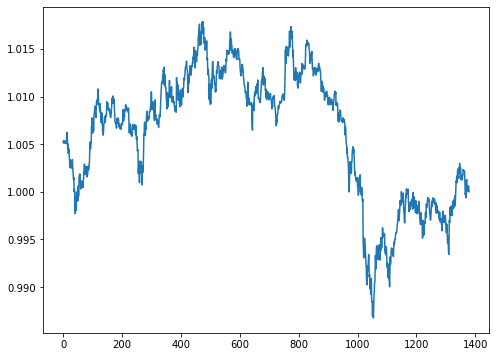

In [289]:
plt.plot(train_x_arr[1, :, 1])

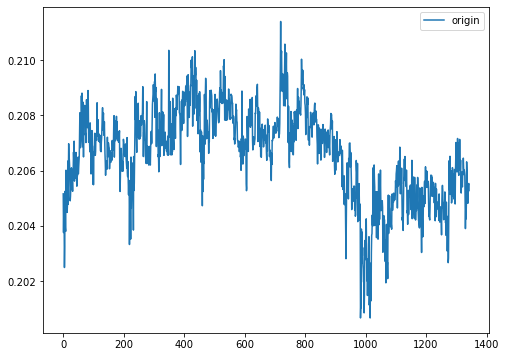

In [290]:
# plt.plot(train_y_arr[0, :83, 1], label='0.3')
plt.plot(frac_x_arr, label='origin')
# plt.plot(example7[0, :], label='0.6')

plt.legend()
plt.show()

In [176]:
def train_val_test_spliter(arr):
    
    n = len(arr)
    num_features = arr.shape[2] - 1
    
    train_arr = arr[0:int(n*0.8), :, 1:]
    val_arr = arr[int(n*0.8):, :, 1:]
    
    n2 = len(train_arr) + len(val_arr)
    
    print(
    f'''
    ======================================================
    Origin length is {n}, then total split length is {n2}
    ======================================================
    train length is {train_arr.shape},
    val length is {val_arr.shape},
    num_features is ({num_features})
    '''
    )
    
    return train_arr, val_arr

In [177]:
print(
    f'''
    train x shape is {train_x_arr.shape},
    train y shape is {train_y_arr.shape},

    
    test x shape is {test_x_arr.shape},
    test y shape is {test_y_arr.shape},
    '''
)


    train x shape is (1203, 1380, 9),
    train y shape is (1203, 120),

    
    test x shape is (5, 1380, 9),
    test y shape is (5, 120),
    


In [178]:
# train & val set
train_X, val_X, train_y, val_y = train_test_split(train_x_arr, train_y_arr, test_size=0.2, shuffle=False)

# test set
test_X = test_x_arr[:, :, 1:] # open col
test_y = test_y_arr

In [179]:
print(
f'''
======================================================
Origin length is {len(train_x_arr)}, then total split length is {len(train_X)}
======================================================
train X length is {train_X.shape}, train y length is {train_y.shape},
val X length is {val_X.shape}, val y length is {val_y.shape},
test X length is {test_X.shape}, test y length is {test_y.shape}
'''
)



Origin length is 1203, then total split length is 962
train X length is (962, 1380, 9), train y length is (962, 120),
val X length is (241, 1380, 9), val y length is (241, 120),
test X length is (5, 1380, 8), test y length is (5, 120)



In [180]:
train_x_mean = train_x_arr.mean(axis=(0, 1))
train_x_std = train_x_arr.std(axis=(0, 1))

train_x_arr = (train_x_arr - train_x_mean) / train_x_std
val_x_arr = (val_x_arr - train_x_mean) / train_x_std
test_x_arr = (test_x_arr - train_x_mean) / train_x_std